# Training a Recurrent Neural Network

In recent years, we saw the revolution that training a dynamical system from data or tasks has provided important insights to understand brain functions. To support this, BrainPy porvides various interfaces to help users train dynamical systems. 

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.enable_x64()
bm.set_dfloat(bm.float64)

bm.set_platform('cpu')

In [2]:
import matplotlib.pyplot as plt

## General usage

In BrainPy, we provide a general interface to build neural networks, supporting feedforward, recurrent, feedback connections. 

#### Model Building

In general, each model is treated as a **node**. Based on the node operations, like feedforward ``>>``, feedback ``<<``, etc., we can create arbitrary **node graph** we want. For example, 

```python

feedforward_net = data >> reservoir >> readout
```

create a simple network in which `data` first feedforward to `reservoir` node, then the output of `reservoir` is readout by a `readout` node. Further, if we try to create a feedback connection from `readout` to `reservoir`, we can use

```python

feedback_net = reservoir << readout
```

After merging it with the previous defined ``feedforward_net``, we can create a network with feedforward and feedback connections:


```python

model = feedforward_net & feedback_net
```

#### Model running & training

Moreover, BrainPy provides various interfaces for network running and training, including the commonly used Ridge Regression method, FORCE learning method, and back-progropagation through time algorithms. Users can create these **runners** and **trainers** with the following codes:

```python

runner = bp.nn.RNNRunner(model, ...)
```

or, 

```python

trainer = bp.nn.RidgeTrainer(model, ...)

trainer = bp.nn.FORCELearning(model, ...)

trainer = bp.nn.BPTT(model, ...)
```


Bellow, we demonstrate these supports with several examples. 

## Echo state network

We first illustrate the training interface of BrainPy using an echo state network. 

For an echo state network, we have three components: an input node ("I"), a reservoir node ("R") for dimension expansion, and an output node ("O") for linear readout. 

<img src="../_static/echo_state_net.png"  width="50%"/>

In [3]:
# create the components we need

i = bp.nn.Input(3)
r = bp.nn.Reservoir(400, spectral_radius=1.4)
o = bp.nn.LinearReadout(3)

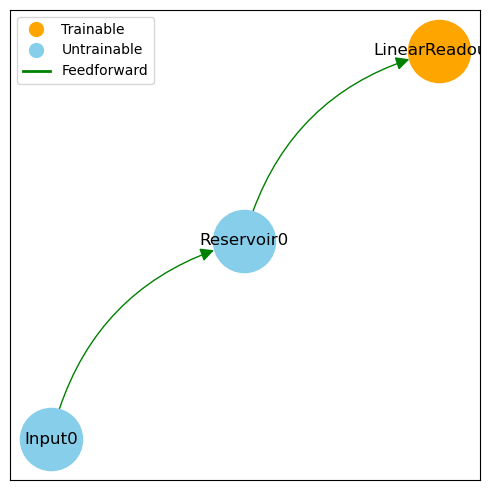

In [4]:
# crerate the model we need

model = i >> r >> o
model.plot_node_graph(fig_size=(5, 5), node_size=2000)

We use this created network to predict the chaotic time series, named as Lorenz attractor. Particurlaly, we expect the network has the ability to predict $P(t+l)$ from $P(t)$, where $l$ is the length of the prediction ahead. 

In [5]:
dt = 0.01
data = bp.datasets.lorenz_series(100, dt=dt)

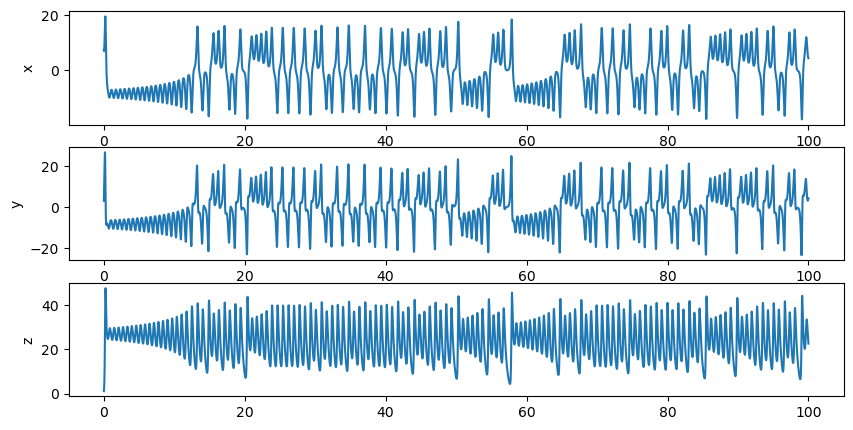

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(data['ts'].numpy(), data['x'].flatten().numpy())
plt.ylabel('x')
plt.subplot(312)
plt.plot(data['ts'].numpy(), data['y'].flatten().numpy())
plt.ylabel('y')
plt.subplot(313)
plt.plot(data['ts'].numpy(), data['z'].flatten().numpy())
plt.ylabel('z')
plt.show()

In [7]:
def get_subset(data, start, end):
    res = {'x': data['x'][start: end],
           'y': data['y'][start: end],
           'z': data['z'][start: end]}
    res = bm.hstack([res['x'], res['y'], res['z']])
    return res.reshape((1, ) + res.shape)

To complish this task, we use Ridge Regression method to train the network. Before that, we first initialize the network with the batch size of 1, and then construct a Ridge Regression trainer. 

In [8]:
model.initialize(num_batch=1)

trainer = bp.nn.RidgeTrainer(model, beta=1e-6)

We warm-up the network with 20 ms. 

In [9]:
warmup_data = get_subset(data, 0, int(20/dt))

outs = trainer.predict(warmup_data)

outs.shape

  0%|          | 0/2000 [00:00<?, ?it/s]

(1, 2000, 3)

The training data is the time series from 20 ms to 80 ms. We want the network has the abilitty to forecast 1 time step ahead. 

In [10]:
x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+1, int(80/dt)+1)

trainer.fit([x_train, y_train])

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Then we test the trained network with the next 20 ms. 

In [11]:
x_test = get_subset(data, int(80/dt), int(100/dt)-1)
y_test = get_subset(data, int(80/dt) + 1, int(100/dt))

predictions = trainer.predict(x_test)

bp.losses.mean_squared_error(y_test, predictions)

  0%|          | 0/1999 [00:00<?, ?it/s]

DeviceArray(0.03279233, dtype=float64)

In [12]:
def plot_difference(truths, predictions):
    truths = truths.numpy()
    predictions = predictions.numpy()

    plt.subplot(311)
    plt.plot(truths[0, :, 0], label='Ground Truth')
    plt.plot(predictions[0, :, 0], label='Prediction')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(312)
    plt.plot(truths[0, :, 1], label='Ground Truth')
    plt.plot(predictions[0, :, 1], label='Prediction')
    plt.ylabel('y')
    plt.legend()
    plt.subplot(313)
    plt.plot(truths[0, :, 2], label='Ground Truth')
    plt.plot(predictions[0, :, 2], label='Prediction')
    plt.ylabel('z')
    plt.legend()
    plt.show()

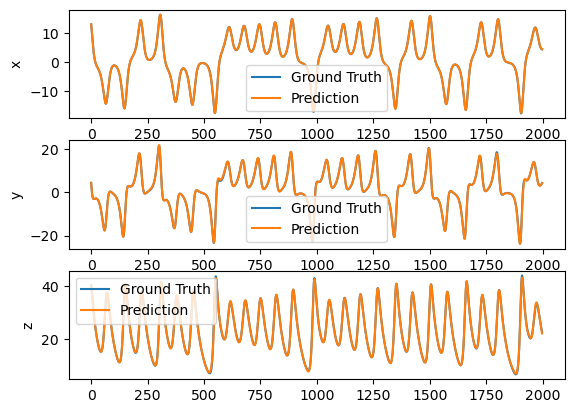

In [13]:
plot_difference(y_test, predictions)
# We can make the task harder to forecast 10 time step ahead. 

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1990 [00:00<?, ?it/s]

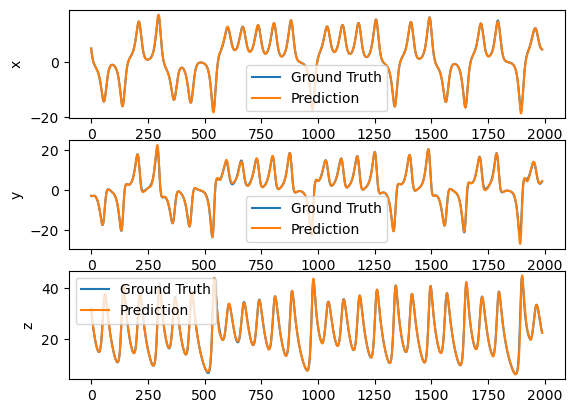

In [14]:
warmup_data = get_subset(data, 0, int(20/dt))
outs = trainer.predict(warmup_data)

x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+10, int(80/dt)+10)
trainer.fit([x_train, y_train])

x_test = get_subset(data, int(80/dt), int(100/dt)-10)
y_test = get_subset(data, int(80/dt) + 10, int(100/dt))
predictions = trainer.predict(x_test)

plot_difference(y_test, predictions)

Or forecast 100 time step ahead. 

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

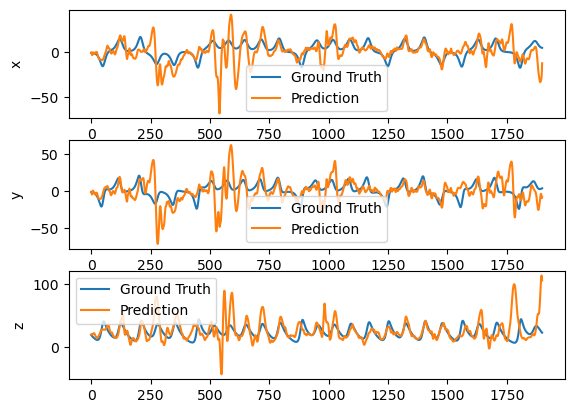

In [15]:
warmup_data = get_subset(data, 0, int(20/dt))
outs = trainer.predict(warmup_data)

x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+100, int(80/dt)+100)
trainer.fit([x_train, y_train])

x_test = get_subset(data, int(80/dt), int(100/dt)-100)
y_test = get_subset(data, int(80/dt) + 100, int(100/dt))
predictions = trainer.predict(x_test)

plot_difference(y_test, predictions)

As you see, forecasting larger time step makes the learning more difficult. 

## Next generation RC

(Gauthier, et. al., Nature Communications, 2021) has proposed a next generation reservoir computing (NG-RC) model by using nonlinear vector autoregression (NVAR). 

![](../_static/NG-RC-vs-Traditional-RC.png)

<p align="center"> <b>(A)</b> A traditional RC processes time-series data using an artificial recurrent neural network. <b>(B)</b> The NG-RC performs a forecast using a linear weight of time-delay states of the time series data and nonlinear functionals of this data.</p>

In BrainPy, we can easily implement this kind of network. Here, let's try to use NG-RC to infer the $z$ variable according to $x$ and $y$ variables. This task is important for applications where it is possible to obtain high-quality information about a dynamical variable in a laboratory setting, but not in field deployment. 

Let's first initialize the data we need. 

In [16]:
dt = 0.02
t_warmup = 10.  # ms
t_train = 20.  # ms
t_test = 50.  # ms
num_warmup = int(t_warmup / dt)  # warm up NVAR
num_train = int(t_train / dt)
num_test = int(t_test / dt)

lorenz_series = bp.datasets.lorenz_series(t_warmup + t_train + t_test,
                                          dt=dt,
                                          inits={'x': 17.67715816276679,
                                                 'y': 12.931379185960404,
                                                 'z': 43.91404334248268})
def get_subset(data, start, end):
  res = {'x': data['x'][start: end],
         'y': data['y'][start: end],
         'z': data['z'][start: end]}
  X = bm.hstack([res['x'], res['y']])
  X = X.reshape((1,) + X.shape)
  Y = res['z']
  Y = Y.reshape((1, ) + Y.shape)
  return X, Y


X_warmup, Y_warmup = get_subset(lorenz_series, 0, num_warmup)
X_train, Y_train = get_subset(lorenz_series, num_warmup, num_warmup + num_train)
X_test, Y_test = get_subset(lorenz_series, num_warmup + num_train, num_warmup + num_train + num_test)

The network architecture is the same with the above echo state network. Specifically, we have an input node, a reservoir node and an output node. To accomplish this task, (Gauthier, et. al., Nature Communications, 2021) used 4 delay history information with stride of 5, and their quadratic polynomial monomials. Therefore, we create the network as:

In [17]:
i = bp.nn.Input(2)
r = bp.nn.NVAR(delay=4, order=2, stride=5)
o = bp.nn.LinearReadout(1, trainable=True)
model = i >> r >> o
model.initialize(num_batch=1)

We train the network using the Ridge Regression method too. 

In [18]:
trainer = bp.nn.RidgeTrainer(model, beta=0.05)

# warm-up
outputs = trainer.predict(X_warmup)
print('Warmup NMS: ', bp.losses.mean_squared_error(outputs, Y_warmup))

# training
trainer.fit([X_train, Y_train])

# prediction
outputs = trainer.predict(X_test)
print('Prediction NMS: ', bp.losses.mean_squared_error(outputs, Y_test))

  0%|          | 0/500 [00:00<?, ?it/s]

Warmup NMS:  4582.351844090572


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Prediction NMS:  0.20419239590114113


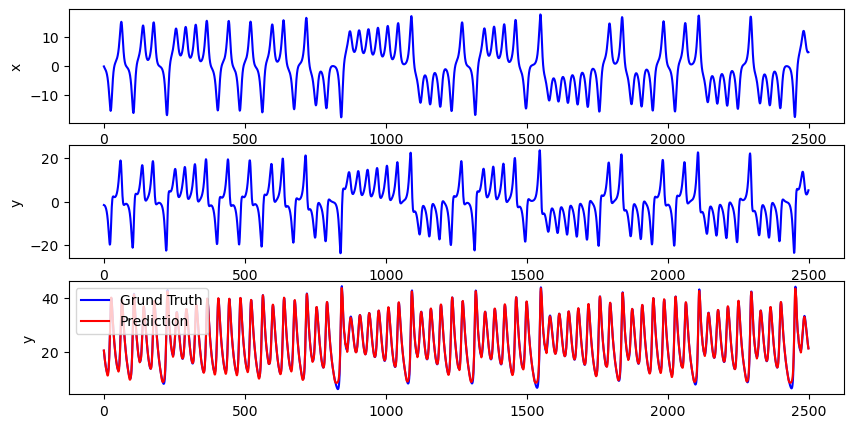

In [19]:
X_test = bm.asarray(X_test).numpy()[0]
Y_test = bm.asarray(Y_test).numpy().flatten()
outputs = bm.asarray(outputs).numpy().flatten()

plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(X_test[:, 0], color='b')
plt.ylabel('x')
plt.subplot(312)
plt.plot(X_test[:, 1], color='b')
plt.ylabel('y')
plt.subplot(313)
plt.plot(Y_test, color='b', label='Grund Truth')
plt.plot(outputs, color='r', label='Prediction')
plt.ylabel('y')
plt.legend()
plt.show()

## Recurrent neural network

In recent years, artificial recurrent neural networks trained with back propagation through time (BPTT) have been a useful tool to study the network mechanism of brain functions. To support training networks with BPTT, BrainPy provides ``brainpy.nn.BPTT`` method. 

Here, we demonstrate how to train an artificial recurrent neural network by using a white noise integration task. In this task, we want our trained GRU model has the ability to integrate white noise. For example, if we has a time series of noise data, 

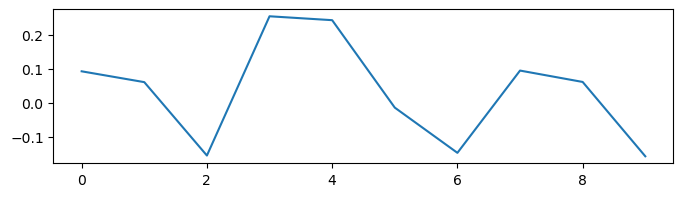

In [20]:
noises = bm.random.normal(0, 0.2, size=10)

plt.figure(figsize=(8, 2))
plt.plot(noises.numpy().flatten())
plt.show()

Now, we want to get a model which can integrate the noise ``bm.cumsum(noises) * dt``: 

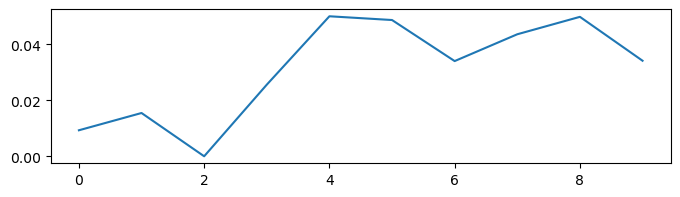

In [21]:
dt = 0.1
integrals = bm.cumsum(noises) * dt

plt.figure(figsize=(8, 2))
plt.plot(integrals.numpy().flatten())
plt.show()

Here, we first define a task which generates the input data and the target integration results. 

In [22]:
from functools import partial

dt = 0.04
num_step = int(1.0 / dt)
num_batch = 10

@partial(bm.jit, dyn_vars=bp.TensorCollector({'a': bm.random.DEFAULT}))
def build_inputs_and_targets(mean=0.025, scale=0.01):
    # Create the white noise input.
    sample = bm.random.normal(size=(num_batch, 1, 1))
    bias = mean * 2.0 * (sample - 0.5)
    samples = bm.random.normal(size=(num_batch, num_step, 1))
    noise_t = scale / dt ** 0.5 * samples
    white_noise_t = bias + noise_t

    # * dt, intentionally left off to get output scaling in O(1).
    targets = bm.cumsum(white_noise_t, axis=1) * dt
    return white_noise_t, targets


def train_data():
  for _ in range(100):
    yield build_inputs_and_targets()

Then, we create and initialize the model. Note here we need the model train its initial state, so we need set ``state_trainable=True`` for the used `VanillaRNN` instance. 

In [23]:
model = (
    bp.nn.Input(1)
    >>
    bp.nn.VanillaRNN(100, weight_initializer=bp.init.Normal(0.85/100 ** 0.5), state_trainable=True)
    >> 
    bp.nn.Dense(1)
)
model.initialize(num_batch=num_batch)

We use ``brainpy.nn.BPTT`` trainer to train this network. 

In [24]:
lr = bp.optim.ExponentialDecay(lr=0.01, decay_steps=1, decay_rate=0.999)
trainer = bp.nn.BPTT(model, 
                     loss=bp.losses.mean_squared_error,
                     optimizer=bp.optim.Adam(lr=lr, eps=1e-1),
                     max_grad_norm=5.0)

In [25]:
trainer.fit(train_data, num_batch=num_batch, num_train=20)

MathError: The length of "grads" must be equal to "self.vars_to_train", while we got 5 != 6!

Finally, let's try the trained network, and test whether it can generate the correct integration results.

In [ ]:
model.init_state(1)

x = bm.random.normal(loc=0.025, scale=0.01, size=(1, num_step, 1))
y = bm.cumsum(x, axis=1) * dt
predict = trainer.predict(y)

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(y.numpy().flatten(), label='Grund Truth')
plt.plot(predict.numpy().flatten(), label='Prediction')
plt.legend()
plt.show()